In [1]:
import pyro
import torch
import torch.optim as optim
import pyro.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot(p, q):
    x = np.linspace(-5.0, +5.0, 50)
    y = np.linspace(-5.0, +5.0, 50)
    xx, yy = np.meshgrid(x, y)

    zz = np.stack([xx.flatten(), yy.flatten()]).T
    zp = p.log_prob(torch.from_numpy(zz)).detach().numpy().reshape(xx.shape)
    zq = q.log_prob(torch.from_numpy(zz)).detach().numpy().reshape(xx.shape)

    plt.contour(x, y, np.exp(zp), cmap=plt.cm.Spectral)
    plt.contourf(x, y, np.exp(zq), cmap=plt.cm.Greys)
    plt.show()

# Optimize KL Divergence $KL(p||q)$

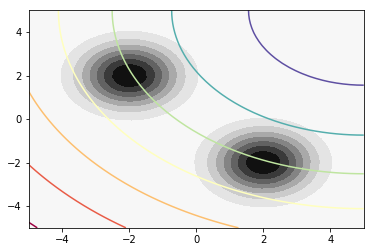

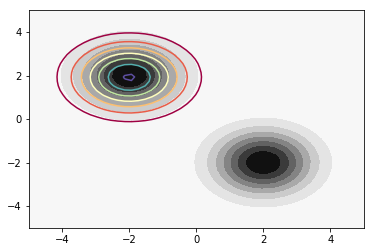

(-10, 10)

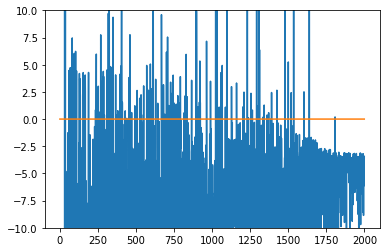

In [3]:
p = dist.MixtureOfDiagNormals(
    locs=torch.tensor([[+5.0, +5.0]], dtype=torch.float64, requires_grad=True),
    coord_scale=torch.tensor([[+10.0, +10.0]], dtype=torch.float64, requires_grad=True),
    component_logits=torch.tensor([1.0], dtype=torch.float64, requires_grad=True)
)
q = dist.MixtureOfDiagNormals(
    locs=torch.tensor([[-2.0, +2.0],
                       [+2.0, -2.0]], dtype=torch.float64),
    coord_scale=torch.tensor([[+1.0, +1.0],
                              [+1.0, +1.0]], dtype=torch.float64),
    component_logits=torch.tensor([1.0, 1.0], dtype=torch.float64)
)
plot(p, q)

losses, stds = [], []
optimizer = optim.SGD([p.locs, p.coord_scale], lr=0.001, momentum=0.9)
for batch in range(2_000):
    optimizer.zero_grad()
    x = p.sample((10, ))
    log_px, log_qx = p.log_prob(x), q.log_prob(x)
    loss = log_px * (1 + log_px - log_qx).detach()
    loss.mean().backward(retain_graph=True)
    optimizer.step()
    losses.append(float(loss.mean()))
    stds.append(float(loss.std()))
    
plot(p, q)
plt.show()
plt.plot(losses)
plt.plot(stds)
plt.ylim([-10, 10])

# Optimize KL Divergence $KL(q||p)$

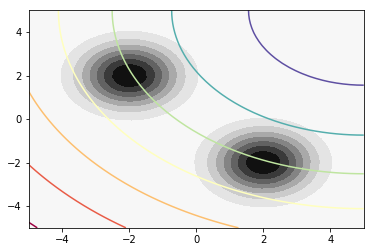

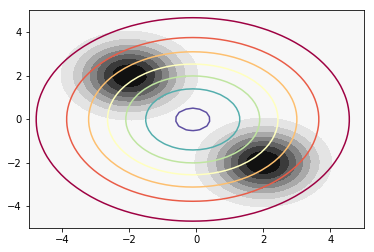

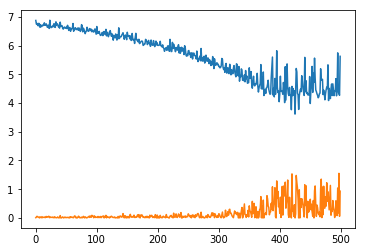

In [4]:
p = dist.MixtureOfDiagNormals(
    locs=torch.tensor([[+5.0, +5.0]], dtype=torch.float64, requires_grad=True),
    coord_scale=torch.tensor([[+10.0, +10.0]], dtype=torch.float64, requires_grad=True),
    component_logits=torch.tensor([1.0], dtype=torch.float64, requires_grad=True)
)

q = dist.MixtureOfDiagNormals(
    locs=torch.tensor([[-2.0, +2.0],
                       [+2.0, -2.0]], dtype=torch.float64),
    coord_scale=torch.tensor([[+1.0, +1.0],
                              [+1.0, +1.0]], dtype=torch.float64),
    component_logits=torch.tensor([1.0, 1.0], dtype=torch.float64)
)
plot(p, q)

losses, stds = [], []
optimizer = optim.SGD([p.locs, p.coord_scale], lr=0.01, momentum=0.95)
for batch in range(500):
    optimizer.zero_grad()
    x = q.sample((5, ))
    log_px = p.log_prob(x)
    loss = - log_px
    loss.mean().backward(retain_graph=True)
    optimizer.step()
    losses.append(float(loss.mean()))
    stds.append(float(loss.std()))

plot(p, q)
plt.plot(losses)
plt.plot(stds)